### Machine Learning (C24), Spring 2024, Project Group F
-----
# Forecasting Electricity Price in the Spain Using Supervised Learning 
### Team: Minho Kang, Lonny Chen, Johannes Müller, Daniyar Imanaliev

This notebook serves as the group write-up submission for Project Group F.

Our GitHub repostiory exists at [MDS_ML_Project](https://github.com/MDS-Mountain-Club/MDS_ML_Project/tree/main).

# 1. Background

**The Spain Energy Price Prediction Project** aims to predict energy prices in Spain using a combination of historical energy generation data and weather forecast data.

## 1 - 1. Data

The data utilized for this project originates from the Kaggle dataset ["Hourly energy generation and weather in Spain"](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather), which includes hourly observations from 2015 to 2018. This dataset integrates energy generation data from the ENTSO-E platform with weather data for five major cities (Bilbao, Barcelona, Madrid, Valencia, and Sevilla) obtained from the Open Weather API. 

### Unit of analyses

Each row is a timestamped hourly observation that contains information about the different
sources of electricity supply in Spain joined with weather data from 5 different big cities
(Bilbao, Barcelona, Madrid, Valencia, Sevilla). The dataset spans hourly from 2015 to 2018,
so we have 35,064 observations \$=([4x365+1]*24)$ in total.

### Target variable

The goal is to develop predictive models that can accurately forecast energy prices in Spain.  Our dependent variable is the actual hourly energy prices ⁠ price actual ⁠ variable. 
Predictive models will use features such as past weather conditions, historical energy generation values, and time-specific data including prices for previous time hour periods (-1, -2, -3 hourly prices).


### Choosing a target for prediction

Our initial project goal was to predict renewable energy generation (solar or wind) for the next 3 hours. 
However, after exploratory data analyses we decided to switch our focus to price prediction, since ⁠ generation solar ⁠ variable looks like an exponential distribution with many values near zero, and ⁠ generation wind ⁠ is a substantially skewed normal curve towards lower values, with high outliers. Meanwhile actual energy prices ⁠ price actual ⁠ has the most "normal looking" distribution with the lowest absolute skew and lowest "coefficient of variation" (std divided by mean). 

## 1 - 2. Models 

We have built the following models:

- Linear Regressions (Ordinary Least Squares, Ridge, Lasso)
- Polynomial Regression (Lasso)
- Kernel Ridge RBF
- ⁠KNN
- Tree Models (Random Forest and XGBoost)
- RNN
- Timeseries Model (SARIMAX)

## 1 - 3. Policy implications

Predicting energy prices for the next hour using machine learning models significantly enhances decision-making in public policy, in particular for support environmental goals by promoting emission reduction and sustainability programs.

# 2. Exploratory Data Analysis

The data preparation and EDA tasks were initially developed in the following files with only the key steps and findings included here for brevity:
1. [01_data_clean_join.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/01_data_clean_join.ipynb): interpolate missing values, join energy and weather datasets
2. [02_data_outliers.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/02_data_outliers.ipynb): identify and resolve data error outliers, output **df_clean.csv**
3. [03_data_explore.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/03_data_explore.ipynb): details in this section

In [1]:
import xgboost as xgb
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from functions import *

In [2]:
df = pd.read_csv('Data/df_clean.csv', index_col='time', parse_dates=['time'])

## 2 - 1. Target variable distributions 

We plotted the distributions of the three target variables that were initially considered and`'price actual'` is the most "normal looking" distribution. This may help the predictive performace of "some" other machine learning algorithms such as linear regression.

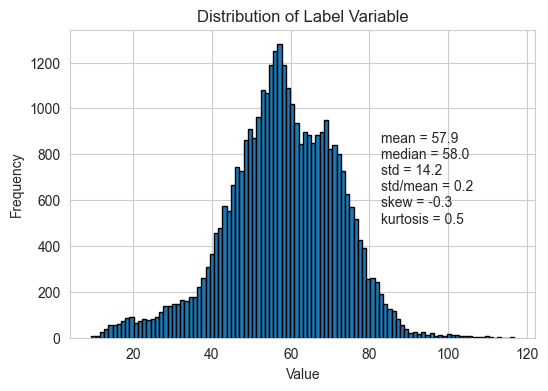

In [3]:
y_col = 'price actual'
y_price = df[y_col]
plt.figure(figsize=(6, 4))
plt.hist(y_price, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Label Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
hist_text(plt, 75, 500, y_price, 1, 'medium')
plt.show()

## 2 - 2. Feature variables (weather) distributions 

We compared interesting weather related features across five cities and observed that:
- `'temp*'` curves do move to the right as we go south, Valencia exhibits some strange dips in the histogram
- `'humidity*'` curve shapes vary more but it roughly varies inversely to temperature by city (e.g., low temp, high humidity)
- `'pressure*'` varies little and seems similar in each city

However, per-city weather variables are unlikely to be important features individually as they collectively contribute to energy generation and load, and ultimately price.

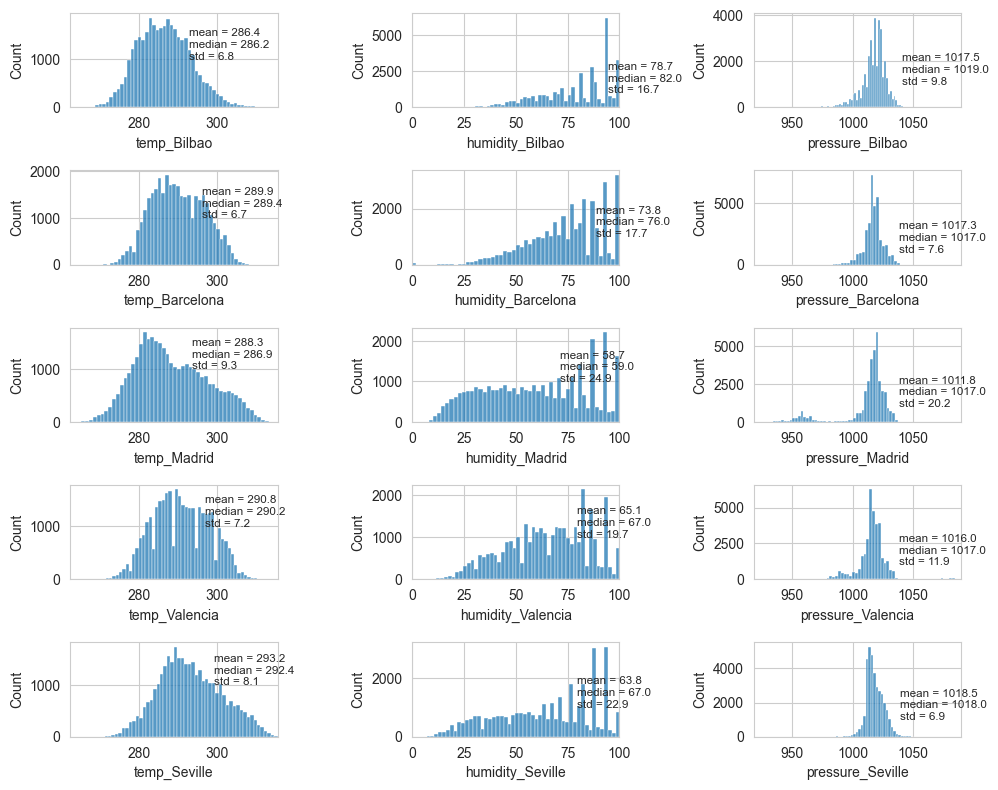

In [7]:
# Setup, order by North to South of Spain
weather_cols = [[col for col in df.columns if keyword in col] for keyword in ['temp', 'humidity', 'pressure']]
for i, _ in enumerate(weather_cols):
    weather_cols[i][0], weather_cols[i][1], weather_cols[i][2], weather_cols[i][3], weather_cols[i][4] = weather_cols[i][1], weather_cols[i][0], weather_cols[i][2], weather_cols[i][4], weather_cols[i][3]

# Get limits for consistent axes
col_mins = [min(min(df[col]) for col in cols) for cols in weather_cols]
col_maxs = [max(max(df[col]) for col in cols) for cols in weather_cols]

# Plots and annotate text
fig, axes = plt.subplots(5, 3, figsize=(10, 8))
for i, x_var in enumerate(weather_cols):
    for j, city in enumerate(x_var):
        sns.histplot(data=df, x=city, bins=50, ax=axes[j][i])
        axes[j][i].set_xlim(left=col_mins[i], right=col_maxs[i])
        hist_text(axes[j][i], np.percentile(df[city], 50), 1000, df[city], 1, 'small', False)  
    
plt.tight_layout()
plt.show()

## 2 - 3. Feature variables (generation) correlations

Which strong correlations exist amongst energy generation variables and what could that tell us about modeling choices?

We observed strong correlations between "fossil coal" generations (+0.77), and moderate correlations between other "fossil" generations. One of our initial potential targets `'generation solar'` does not have any, even moderate, correlations, while the other,`'generation wind onshore',` has moderate negative correlations with some "fossil" generations which may suggest a balancing relationship

If `'generation*'` variables prove to be important predictors, we could consider **dimensionality reduction** techniques to simplify model fitting

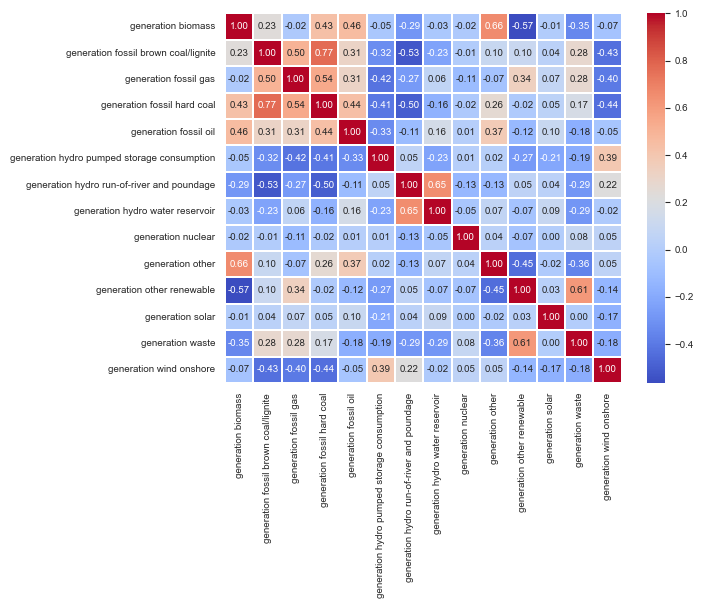

In [11]:
# Calculate correlations
df2 = df.copy()
generation_cols = [col for col in df2.columns if 'generation' in col]
df2_generation_corr = df2[generation_cols].corr(method='pearson')

# Plot heatmap
sns.heatmap(df2_generation_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.3)
plt.rcParams['font.size'] = 8

## 2 - 4. Target variable correlations

Any features which strongly correlate with the target variable, `'price actual'`, may be expected to be important predictors in our modeling.

Using Pearson correlation which checks for **linear** correlation, we observed that:
- There are no moderate or strong correlations with any of the weather variables!
- Strong to very strong correlations relate to previous hour or "day ahead" prices
- Moderate correlations relate to fossil generation (being more expensive?) and total loads (market effect?)

In [140]:
s_y_corr = df.corr(method='pearson')[y_col].sort_values(ascending=False)
s_y_corr[abs(s_y_corr) >= 0.3]

price actual                                   1.000000
price_prev_1                                   0.966790
price_prev_2                                   0.900490
price_prev_3                                   0.821566
price day ahead                                0.732167
generation fossil hard coal                    0.465953
generation fossil gas                          0.461567
total load forecast                            0.435918
total load actual                              0.435638
generation fossil brown coal/lignite           0.364006
generation hydro pumped storage consumption   -0.426251
Name: price actual, dtype: float64

## 2 - 5. Time-based EDA

With the time component of these datasets being the most salient "feature", we plotted time-series exploration to look for global trends and seasonal variations.

We started with just plotting the target variables' `lineplot` trend over time (color-split below by training and test time periods). There is surprisingly no obvious global trend but some pattern of higher prices towards the end of each year.

Using a series of `boxplot`'s to analyze different seasonalities:
- `hour`: a smooth curve with local price maximums in the morning and evening
- `weekday`: lower price means on the **weekend** days
- `month`: a pronounced price dip during the **spring** months of March and April

Such seasonalities motivate the use of specific **time-series** modeling methods, implemented in **section 4.7** below. 

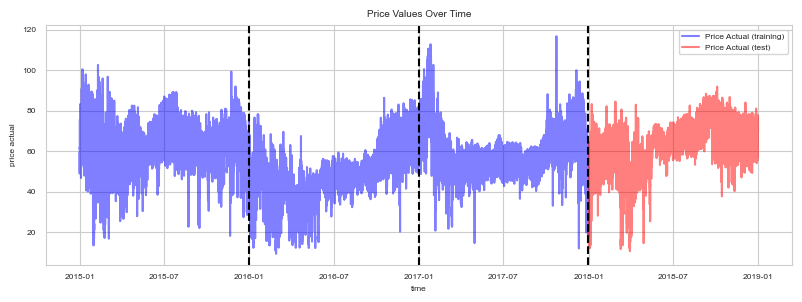

In [141]:
# Split train and test for plot
train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
df_train, df_test = split_by_date(df, train_end_date)

# Create plot and lines for train/test and year boundaries
fig, ax = plt.subplots(figsize=(8, 3))
sns.lineplot(data=df_train, x=df_train.index, y=y_col, label='Price Actual (training)', color='blue', alpha=0.5, ax=ax)
sns.lineplot(data=df_test, x=df_test.index, y=y_col, label='Price Actual (test)', color='red', alpha=0.5, ax=ax)
for year_end in ['2015-12-31', '2016-12-31', '2017-12-31']:
    plt.axvline(x=pd.to_datetime(year_end), color='black', linestyle='--')

ax.set_title('Price Values Over Time')
plt.tight_layout()
plt.show()

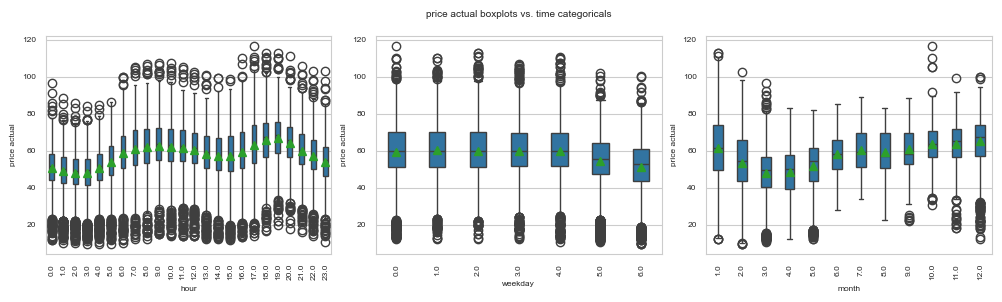

In [142]:
# Plot time-categorical boxplots to look for patterns
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for i, x_var in enumerate(['hour', 'weekday', 'month']):
    sns.boxplot(data=df, y=y_col, x=x_var, width=0.4, showmeans=True, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    if i == 1:
        axs[i].set_title(f'{y_col} boxplots vs. time categoricals\n')

plt.tight_layout()
plt.show()

# 3. Feature Engineering using XGBoost 

Here, as one part of feature engineering, we are going to do dimensional reduction using XGBoost. Specifically, we will use only top 10 important features based on the result of feature importance from XGBoost. 

## 3 - 1. Data Preprocessing 

In [143]:
X = df.drop(columns=['price actual'])
y_price = df['price actual']

In [144]:
# Split the data into train and test based on specific time '2017-12-31 23:00:00+00:00'
train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')

# Here, we are using ourselves made function named "split_by_date"
X_train_scaled, X_test_scaled = split_by_date_and_standardize(X, train_end_date)
y_price_train, y_price_test = split_by_date(y_price, train_end_date)

## 3 - 2. Hyperparameter Tuning

In [145]:
xgb_reg = xgb.XGBRegressor(eval_metric = "rmse")
param_grid = {"max_depth": [4,5,6],
              "n_estimators" : [50, 100, 150],
              "learning_rate": [0.01, 0.015]
    
}
search = GridSearchCV(xgb_reg, param_grid, cv=5).fit(X_train_scaled, y_price_train)
xgb_reg=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                        eval_metric = "rmse")


## 3 - 3. Find top 10 features

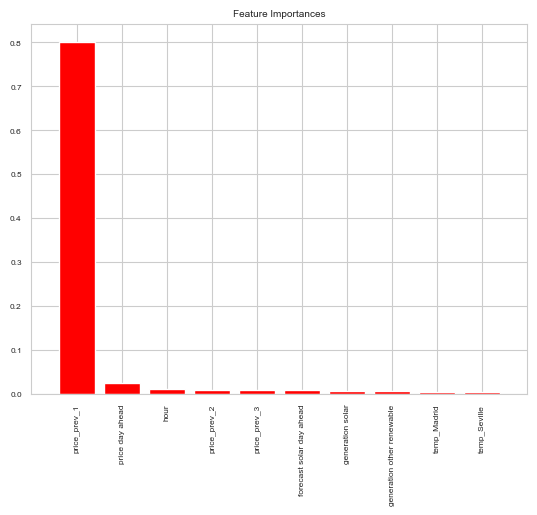

In [146]:
xgb_reg.fit(X_train_scaled, y_price_train)
importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[::-1]
top_10_indices = indices[:10]
top_10_features = X_train_scaled.columns[top_10_indices]
plt.figure()
plt.title('Feature Importances')
plt.bar(range(len(top_10_indices)), importances[top_10_indices], color='r', align='center')
plt.xticks(range(len(top_10_indices)), top_10_features, rotation=90)
plt.xlim([-1,len(top_10_indices)])
plt.show()

X_10 = df[top_10_features]

# 4. Model Evaluation

## 4 - 0. Introduction

### 4 - 0 - 1. Data prepration

* This data spans hourly from 2015 to 2018. We set until 2017 as train data and 2018 as test data. 
* We decide to standardize X data (dataset without y variable) for every model for improved model performance (neural networks, KNN, regularization), and balanced feature comparisons. However, using standardized y is depending on models because this doesn't consistently improve every model

In [147]:
train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')

# Standardize X variable always
X_train_scaled, X_test_scaled = split_by_date_and_standardize(X_10,train_end_date)

# Stadardize Y variable (This is depending on what model you use)
y_price_train, y_price_test = split_by_date(y_price, train_end_date)
scaler_y = StandardScaler()
y_price_train_scaled = scaler_y.fit_transform(y_price_train.values.reshape(-1, 1))
#y_price_test_scaled = scaler_y.fit_transform(y_price_test.values.reshape(-1, 1))
y_price_test_scaled = scaler_y.transform(y_price_test.values.reshape(-1, 1))

### 4 - 0 - 2. Dummy model

First, for comparing supervised learning models with a naive way, we make dummy regressor which predict a value as the mean of all train dataset

In [148]:
# Setup model evaluation dictionary, use with function `add_model_eval`
model_eval = dict()

# Baseline "dummy" prediction based on y-train mean
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_scaled, y_price_train)
y_pred_dummy = dummy_model.predict(X_test_scaled)

# Calculate Test RMSE etc.
print("RMSE of baseline dummy model for predicting price:", root_mean_squared_error(y_price_test, y_pred_dummy))
model_eval = add_model_eval(model_eval, 'Baseline dummy (y-train mean)', y_price_test, y_pred_dummy)

RMSE of baseline dummy model for predicting price: 14.282970288965133


## 4 - 1. Linear Regression

The linear regression models covered in class were run using only the top ten features selected from XGBoost (see **section 3.3** above). A `TimeSeriesSplit` (where only past data is used as training for successive splits) cross-validation on different alpha parameter values was done for Ridge and Lasso regression to find the best alpha's, applying the One-Standard-Error rule as well. The chosen alpha was used to re-build the Ridge or Lasso model to arrive at the best RMSE value when predicting the unseen test data. The detailed workflow (including more plots) can be seen at [linear_regression.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/Regression/linear_regression.ipynb).

RMSE values in the 2.75-2.77 range were seen across the three linear regerssion models which is a very good result, noting also the high R-squared values (see comparison table in **section 5**).

A somewhat surprisingly observation was that OLS performs slightly better than Ridge, and Ridge slightly better than Lasso. But according to ChatGPT, there are situations where this would arise.

### 4 - 1 - 1. Ordinary Least Squares (OLS)

#### 4 - 1 - 1 - 1. Prediction and Evaluation

In [149]:
# Create and fit
ols_model = LinearRegression() 
ols_model.fit(X_train_scaled, y_price_train)

# Predict and evaluate with metrics
y_pred_ols = ols_model.predict(X_test_scaled) 
print("RMSE of linear regression (OLS) for predicting price:", root_mean_squared_error(y_price_test, y_pred_ols))
model_eval = add_model_eval(model_eval, 'Linear Regression (OLS)', y_price_test, y_pred_ols)

RMSE of linear regression (OLS) for predicting price: 2.754342719669341


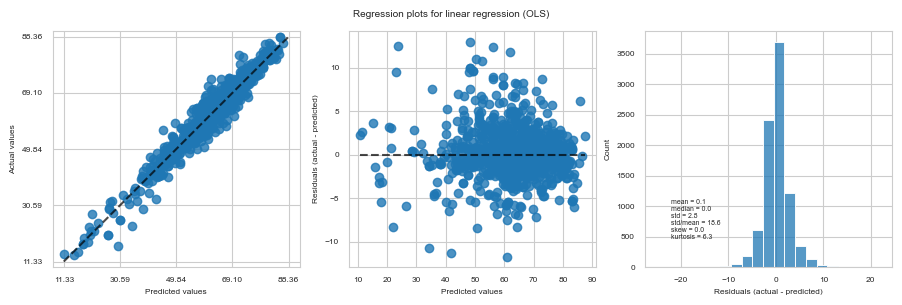

In [150]:
# Check plots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_price_test, y_pred_ols, fig, axes, 'Regression plots for linear regression (OLS)')

### 4 - 1 - 2. Ridge Regression

#### 4 - 1 - 2 - 1. Find Best Alpha

In [151]:
# Perform time-series cross-validation to find best alpha and apply 1SE rule
# Uses custom functions from functions.py
tscv = TimeSeriesSplit(n_splits=2)
ridge_alphas = np.logspace(-5, 5, 20)
ridge_scores = alpha_scores_cross_val(Ridge, X_train_scaled, y_price_train, tscv, ridge_alphas)
best_alpha_ridge, one_std_ridge = best_alpha_one_se_rule(ridge_scores)
print(f'The best ridge regression alpha is at: {best_alpha_ridge}')

The best ridge regression alpha is at: 20.6913808111479


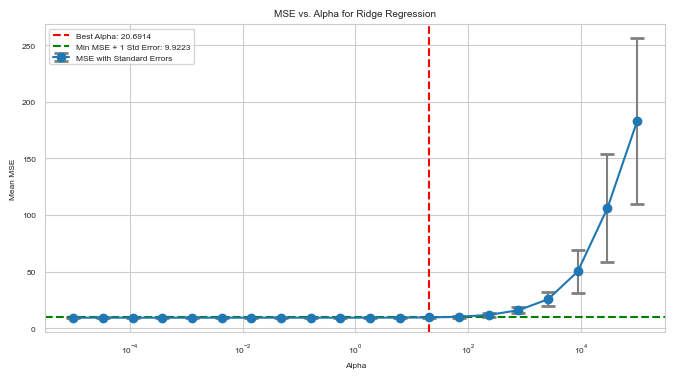

In [152]:
plot_mse_vs_parameter(ridge_scores['alphas'], ridge_scores['avg_mse'], ridge_scores['std_errors'], 
                      best_alpha_ridge, one_std_ridge, True, 'Alpha', 'Ridge Regression')

#### 4 - 1 - 2 - 2. Prediction and Evaluation

In [153]:
# Ridge model with best alpha: create and fit
best_ridge_model = Ridge(alpha=best_alpha_ridge)
best_ridge_model.fit(X_train_scaled, y_price_train)

# Predict and evaluate
y_pred_ridge = best_ridge_model.predict(X_test_scaled)
print("RMSE of ridge regression for predicting price:", root_mean_squared_error(y_price_test, y_pred_ridge))
model_eval = add_model_eval(model_eval, 'Ridge Regression', y_price_test, y_pred_ridge)

RMSE of ridge regression for predicting price: 2.756268583743204


### 4 - 1 - 3. Lasso Regression

#### 4 - 1 - 3 - 1. Find Best Alpha

In [154]:
# Perform time-series cross-validation to find best alpha and apply 1SE rule
# Uses custom functions from functions.py
tscv = TimeSeriesSplit(n_splits=2)
lasso_alphas = np.logspace(-5, 5, 20)
lasso_scores = alpha_scores_cross_val(Lasso, X_train_scaled, y_price_train, tscv, lasso_alphas)
best_alpha_lasso, one_std_lasso = best_alpha_one_se_rule(lasso_scores)
print(f'The best lasso regression alpha is at: {best_alpha_lasso}')

The best lasso regression alpha is at: 0.04832930238571752


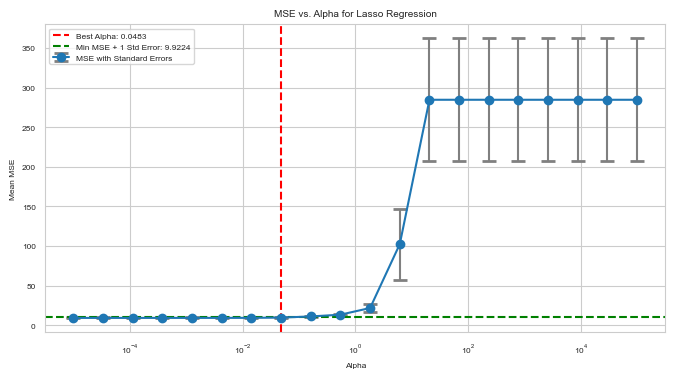

In [155]:
plot_mse_vs_parameter(lasso_scores['alphas'], lasso_scores['avg_mse'], lasso_scores['std_errors'],
                      best_alpha_lasso, one_std_lasso, True, 'Alpha', 'Lasso Regression')

#### 4 - 1 - 3 - 2. Prediction and Evaluation

In [156]:
# Lasso model with best alpha: create and fit
best_lasso_model = Lasso(alpha=best_alpha_lasso)
best_lasso_model.fit(X_train_scaled, y_price_train)

# Predict and evaluate
y_pred_lasso = best_lasso_model.predict(X_test_scaled)
print("RMSE of lasso regression for predicting price:", root_mean_squared_error(y_price_test, y_pred_lasso))
model_eval = add_model_eval(model_eval, 'Lasso Regression', y_price_test, y_pred_lasso)

RMSE of lasso regression for predicting price: 2.775638429049703


## 4 - 2. Polynomial Regression

With the complexity and time component of this dataset, polynomial regression was worth trying, including trying a range of degrees, as another layer of iteration on top of finding the best alpha parameter for each degree. To simplify the work, all ten features are given exponent terms. The detailed workflow (including more plots) can be seen at [polynomial_regression.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/Regression/polynomial_regression.ipynb).

The results are promising as the best degree term of two (all features also having a squared term) gives us the best test-RMSE value yet!

### 4 - 2 - 1. Find Best Degrees

In [157]:
# Loop setup
tscv = TimeSeriesSplit(n_splits=2)
lasso_alphas = np.logspace(-5, 5, 20)
lasso_degrees = np.arange(1, 6, 1) #1..5
poly_model_eval = dict()

# Loop through different degrees
for degree in lasso_degrees:
    
    # Data setup for THIS degree of polynomial terms
    X_10_poly = polynomial_terms(X_10, X_10.columns, degree)
    X_train_poly_scaled, X_test_poly_scaled = split_by_date_and_standardize(X_10_poly, train_end_date)
   
    # Find best alpha for THIS degree
    lasso_scores = alpha_scores_cross_val(Lasso, X_train_poly_scaled, y_price_train, tscv, lasso_alphas)
    df_lasso_scores = pd.DataFrame(lasso_scores)
    best_alpha_lasso, _ = best_alpha_one_se_rule(lasso_scores)
    best_std_error = df_lasso_scores.loc[df_lasso_scores['alphas'] == best_alpha_lasso, 'std_errors'].iloc[0]
    
    # Create, fit, and predict model with best alpha
    best_lasso_model = Lasso(alpha=best_alpha_lasso)
    best_lasso_model.fit(X_train_poly_scaled, y_price_train)
    y_pred_lasso = best_lasso_model.predict(X_test_poly_scaled)
    
    # Evaluate
    poly_model_eval = add_model_eval(poly_model_eval, degree, y_price_test, y_pred_lasso)
    poly_model_eval[degree]['best_alpha'] = best_alpha_lasso
    poly_model_eval[degree]['best_std_error'] = best_std_error

In [158]:
# Find best degrees
df_poly_model_eval = pd.DataFrame(poly_model_eval).T
best_mse = df_poly_model_eval['MSE'].min()
best_max_degree = int(df_poly_model_eval[df_poly_model_eval['MSE'] == best_mse].index[0])
print(f'The best polynomial degrees is: {best_max_degree}')

The best polynomial degrees is: 2


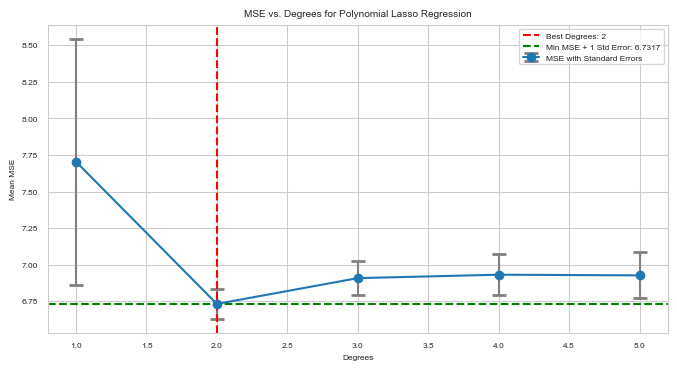

In [159]:
# Plot MSE vs. degrees
plot_mse_vs_parameter(df_poly_model_eval.index, df_poly_model_eval['MSE'], df_poly_model_eval['best_std_error'],
                   best_max_degree, best_mse, False, 'Degrees', 'Polynomial Lasso Regression')

### 4 - 2 - 2. Prediction and Evaluation

In [160]:
# Setup data
X_10_poly = polynomial_terms(X_10, X_10.columns, best_max_degree)
X_train_poly, X_test_poly = split_by_date(X_10_poly, train_end_date)
scaler_x_poly = StandardScaler()
X_train_poly_scaled = scaler_x_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_x_poly.transform(X_test_poly)

# Create, fit model
best_lasso_model = Lasso(alpha=df_poly_model_eval['best_alpha'].min())
best_lasso_model.fit(X_train_poly_scaled, y_price_train)

# Predict and evaluate
y_pred_poly_lasso = best_lasso_model.predict(X_test_poly_scaled)
print("RMSE of polynomial (lasso) regression for predicting price:", root_mean_squared_error(y_price_test, y_pred_poly_lasso))
model_eval = add_model_eval(model_eval, 'Polynomial Lasso Regression', y_price_test, y_pred_poly_lasso)

RMSE of polynomial (lasso) regression for predicting price: 2.594557100247647


## 4 - 3. Kernel Ridge RBF

Here, we apply peculiar unique method: Kernel Ridge with RBF. RBF kernel weights more on the near dataset. We looked forward to that RBF would perform well. But in reality, it's poorer than linear regression.  
P.S. We skip the hyperparameter tuning, because it takes so long time.

In [161]:
# Create, fit model
knrl_rbf = KernelRidge(kernel = 'rbf')
knrl_rbf.fit(X_train_scaled, y_price_train)
y_price_pred_knrl_rbf = knrl_rbf.predict(X_test_scaled)
#RMSE
rmse_price_knrl_rbf = root_mean_squared_error(y_price_test, y_price_pred_knrl_rbf)
print("RMSE of Kernel Ridge with RBF for predicting price:", rmse_price_knrl_rbf)
model_eval = add_model_eval(model_eval, 'Kernel Ridge with RBF', y_price_test, y_price_pred_knrl_rbf)

RMSE of Kernel Ridge with RBF for predicting price: 3.704523562478479


## 4 - 4. KNN

Even though it's seems to be improper to apply KNN to time series data, we just try for curiosity. For sure, the performance is the worst among models so far (RMSE: about 4). You can see this at [KNN_final.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/KNN/KNN_final.ipynb)

### 4 - 4 - 1. Grid Search 

In [162]:
knn = KNeighborsRegressor()
# Set the candidates with 9,11,13,15,17
param_grid = {
    'n_neighbors': [9,11,13,15,17],
    'metric': ['euclidean', 'manhattan']
}
cv_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)

### 4 - 4 - 2. Prediction and Evaluation

In [163]:
cv_knn.fit(X_train_scaled, y_price_train_scaled)

# Prediction 
y_price_pred_scaled_knn = cv_knn.predict(X_test_scaled)
y_price_pred_knn = scaler_y.inverse_transform(y_price_pred_scaled_knn.reshape(-1,1))

# RMSE
print("RMSE of KNN for predicting price:", root_mean_squared_error(y_price_test, y_price_pred_knn))
model_eval = add_model_eval(model_eval, 'K-Nearest Neighbours (KNN)', y_price_test, y_price_pred_knn)

RMSE of KNN for predicting price: 3.9559091088602476


## 4 - 5. Tree models (Random Forest and XGboost)

### 4 - 5 - 1. Random Forest

Random Forest is the most representative ensemble tree model. So we can't skip this model. However, for time, we skip hyperparameter tuning

In [164]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_price_train_scaled)
y_price_pred_scaled_rf = rf.predict(X_test_scaled)
y_price_pred_rf = scaler_y.inverse_transform(y_price_pred_scaled_rf.reshape(-1,1))
# RMSE
print("RMSE of Random Forest for predicting price:", root_mean_squared_error(y_price_test, y_price_pred_rf))
model_eval = add_model_eval(model_eval, 'Random Forest', y_price_test, y_price_pred_rf)

RMSE of Random Forest for predicting price: 2.3975623343117913


### 4 - 5 - 2. XGboost

We already did hyperparameter tunding at the Section 3. So, here, we just bring the best parameter. It's poorer than random forest.

In [165]:
xgb_reg=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                        eval_metric = "rmse")
xgb_reg.fit(X_train_scaled, y_price_train_scaled)
y_price_pred_scaled_xgb = xgb_reg.predict(X_test_scaled)
y_price_pred_xgb = scaler_y.inverse_transform(y_price_pred_scaled_xgb.reshape(-1,1))

# RMSE
print("RMSE of XGB for predicting price:", root_mean_squared_error(y_price_test, y_price_pred_xgb))
model_eval = add_model_eval(model_eval, 'XGBoost', y_price_test, y_price_pred_xgb)

RMSE of XGB for predicting price: 2.798678066957824


## 4 - 6. RNN

Recurrent Neural Network is the most representative time series specialized deep learning model. So it's obvious to apply this model to our dataset. Even though its performance is better than almost models so far (RMSE: 2.57), it's poorer than Random Forest. You can see the model at [RNN_final.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/NeuralNetwork/RNN_final.ipynb)

### 4 - 6 - 1. Grid Search

In [166]:
X_train_scaled_rnn = X_train_scaled.to_numpy().reshape(-1,1,10)
X_test_scaled_rnn = X_test_scaled.to_numpy().reshape(-1,1,10)

y_price_train_scaled_rnn = scaler_y.fit_transform(y_price_train.values.reshape(-1, 1))
y_price_test_scaled_rnn = scaler_y.transform(y_price_test.values.reshape(-1, 1))

def create_rnn_model(n_neurons):
    model = Sequential()
    model.add(SimpleRNN(n_neurons, input_shape=(1, n_features)))
    model.add(Dense(1))  # No activation function for regression
    model.compile(optimizer='adam', loss='mse')  # Using mean squared error for regression
    return model


n_features = X_train_scaled.shape[1]
n_neurons = [10, 20, 30]
param_grid = dict(model__n_neurons=n_neurons)

model_candi = KerasRegressor(model=create_rnn_model)
grid_rnn = GridSearchCV(model_candi, param_grid, cv=5, n_jobs=-1).fit(X_train_scaled_rnn,y_price_train_scaled_rnn)


822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4264


### 4 - 6 - 2. Prediction and Evaluation

In [167]:
# Prediction
best_rnn = grid_rnn.best_estimator_
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
best_rnn.fit(X_train_scaled_rnn, y_price_train_scaled_rnn, epochs=50, batch_size=20, validation_split=0.2,
                            verbose=0)
y_price_pred_scaled_rnn = best_rnn.predict(X_test_scaled_rnn).reshape(-1,1)
y_price_pred_rnn = scaler_y.inverse_transform(y_price_pred_scaled_rnn)
rmse_price_rnn = root_mean_squared_error(y_price_test, y_price_pred_rnn)
print("RMSE for predicting price:", rmse_price_rnn)
model_eval = add_model_eval(model_eval, 'RNN', y_price_test, y_price_pred_rnn)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE for predicting price: 2.572088175704799


### 

## 4 - 7. Time Series Model

From various time-series models, we utilyzed SARIMAX model (The Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors). SARIMAX is a time series forecasting technique that extends the traditional ARIMA model to account for seasonality and external factors. SARIMAX model is extension of ARIMA model and part of auto regressive time series models

SARIMAX model is suitable for energy price prediction since during exploratory data analysis we identified that price data has a strong seasonal effect, as well as our dataset has other variables which can serve as Exogenous Regressors for SARIMAX model

### 4 - 7 - 1 Building function for SARIMAX

In [168]:
def sarimax_model_selection(y_train, X_train, y_test, X_test, p, d, q, P, D, Q, s):
    """
    Fits a SARIMAX model with the given parameters and returns the RMSE on the test set.

    Parameters:
    - y_train: training target series.
    - X_train: training exogenous variables (if any).
    - y_test: testing target series.
    - X_test: testing exogenous variables (if any).
    - p: AR order for non-seasonal model.
    - d: Differencing order for non-seasonal model.
    - q: MA order for non-seasonal model.
    - P: AR order for seasonal model.
    - D: Differencing order for seasonal model.
    - Q: MA order for seasonal model.
    - s: Number of observations per season (seasonal periodicity).

    Returns:
    - rmse: Root Mean Square Error of the model's forecast on the test set.
    - results: Fitted SARIMAX model object containing detailed diagnostic information about the model.
    - forecast: Forecast object containing information like predicted values, confidence intervals, etc.,
    for the test set.
    - mean_forecast: Array of predicted mean values from the forecast, which can be directly 
    compared to y_test for evaluation.

    """
    model = SARIMAX(y_train,
                    exog=X_train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=len(y_test), exog=X_test)
    mean_forecast = forecast.predicted_mean

    rmse = mean_squared_error(y_test, mean_forecast, squared=False)
    return rmse, results, forecast, mean_forecast

### 4 - 7 - 2. Tuning the SARIMAX model for the best parameters

Let's start from parameters p=1, d=0, q=1, P=1, D=0, Q=1, based on ASF and PASF plots (please refer to ARIMA folder in Github)\
Unfortunately, due to limitation of computational power, grid search or cross validation is not possible, however, we can identify parameters by hand. Here, for simplicity, we just showed the result of the best parameters.

In [175]:
#p=1, d=0, q=1, P=1, D=0, Q=1
rmse_price_sarimax, results_1, forecast_1, mean_forecast_1 = sarimax_model_selection(y_price_train, 
                                                                         X_train_scaled,
                                                                         y_price_test,
                                                                         X_test_scaled,
                                                                         1, 0, 1, 1, 0, 1, 12)
model_eval = add_model_eval(model_eval, 'SARIMAX', y_price_test, mean_forecast_1)
print("RMSE of SARIMAX for predicting price:", rmse_price_sarimax)

RMSE of SARIMAX for predicting price: 2.852698822304837


# 5. The final model

Here we do a final comparison of all trained and evaluated models based on the Root Mean Square Error (RMSE) for predicting the test data.

In [176]:
# Display final comparison table as a DataFrame
model_summary = pd.DataFrame(model_eval).T.sort_values('RMSE')
model_summary

,MSE,RMSE,R2,MAE,MAPE
Random Forest,5.748305,2.397562,0.961435,1.683274,0.029435
RNN,6.615638,2.572088,0.955616,1.849357,0.032096
Polynomial Lasso Regression,6.731727,2.594557,0.954837,1.813470,0.032168
Linear Regression (OLS),7.586404,2.754343,0.949103,1.884506,0.033580
Ridge Regression,7.597017,2.756269,0.949032,1.883995,0.033580
Lasso Regression,7.704169,2.775638,0.948313,1.887801,0.033689
XGBoost,7.832599,2.798678,0.947452,2.053545,0.037722
SARIMAX,8.137891,2.852699,0.945403,2.155857,0.037464
Kernel Ridge with RBF,13.723495,3.704524,0.907930,2.576415,0.042240
K-Nearest Neighbours (KNN),15.649217,3.955909,0.895011,2.871447,0.049699


In [177]:
lowest_rmse_model = model_summary['RMSE'].idxmin()
lowest_rmse = model_summary.loc[lowest_rmse_model,'RMSE']

print(f"The best model is {lowest_rmse_model} and its RMSE is {lowest_rmse}")

The best model is Random Forest and its RMSE is 2.3975623343117913


## 5 - 1. Prediction and residuals analysis

The three plots below show visually how well the predicted price tracks the true price for the test data of 2018 using our best performing model of `RandomForestRegressor` 🌲🌳💪🏼.
1. True and predicted vs. time `lineplot`: the prediction tracks the true price very well throughout the year with no large errors visible.
2. Residual (true minus predicted) vs. time `lineplot`: the residuals (prediction errors) look to be centered at zero with some larger erorrs in January, March, and October. These may be due to sudden physical or human events which caused changes in price which were well beyond our prediction.
3. Residual vs. time-categorical `boxplot`'s: the prediction errors all look cenetred at zero for all time elements with more outlier spread on some months (from point #2), and hours of 23:00, 00:00 (being probably just one-off events).

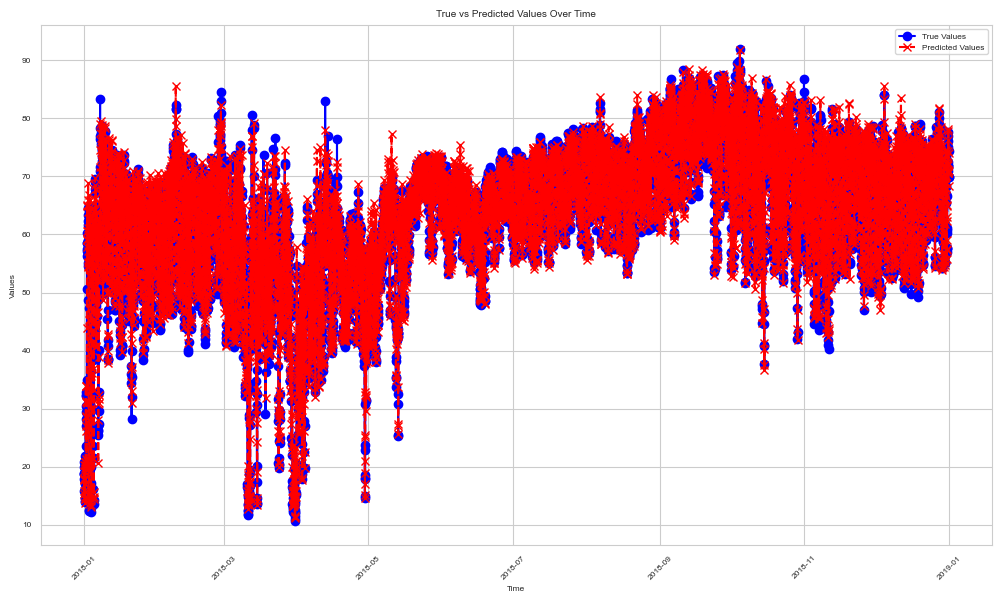

In [178]:
# Plot time-series true vs. prediction of best model
plot_true_pred(X_test_scaled, y_price_pred_rf, y_price_test)

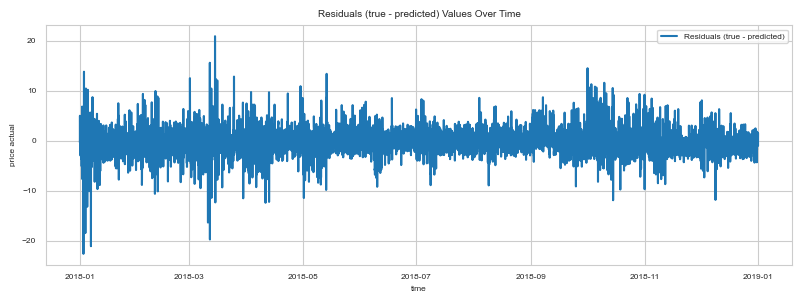

In [179]:
# Setup residuals data
y_residual = y_price_test - y_price_pred_rf.reshape(-1)

# Time-series line plot
fig, ax = plt.subplots(figsize=(8, 3))
sns.lineplot(x=y_price_test.index, y=y_residual, label='Residuals (true - predicted)', ax=ax)

ax.set_title('Residuals (true - predicted) Values Over Time')
plt.tight_layout()
plt.show()

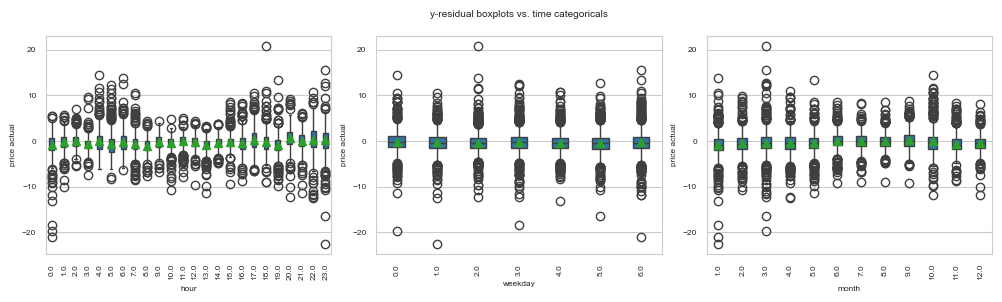

In [180]:
# Plot time-categorical boxplots to look for patterns
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for i, x_var in enumerate(['hour', 'weekday', 'month']):
    sns.boxplot(data=df, y=y_residual, x=x_var, width=0.4, showmeans=True, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    if i == 1:
        axs[i].set_title('y-residual boxplots vs. time categoricals\n')

plt.tight_layout()
plt.show()

# 6. Conclusion

### Final Model Selection

After evaluating multiple models for the energy price prediction, we find that Random Forest model has the best performance in comparison with other models.

Random Forest model has the lowest RMSE (2.3976) and MSE (5.7483), indicating it has the best predictive accuracy among the evaluated models. RNN and Polynomial Lasso Regression also show strong performance with RMSE values of 2.5492 and 2.5925, respectively.

From explainability perspective simple models like regression models(e.g. OLS regression) has higher interpretability, making it easy to understand the impact of each feature on energy prices.

However, for the Energy Prediction Project purposes, a predictive accuracy is the highest priority, and, accordingly, Random Forest is the optimal choice.

### Policy Implications of Energy Price Predictive Models

Our predictive models for energy prices will allow to have  an effective tool for ensuring a functioning a more stable and predictable market.  

For example, policy stakeholders can use these predictions to implement measures that tackle price volatility, reducing uncertainty for household consumers and businesses.

Moreover, accurate predictions enable the design of more effective regulatory measures and price controls. Public stakeholders can set price caps, subsidies, or taxes that help manage energy costs for consumers while encouraging efficient energy use and reducing environmental impact allowing to achieve sustainability goals, e.g stimulating renewable energy generation and decarbonization.